# Heartbeat -- Heart Sound Classification

#### Rui Luo, Yumei Chen, Hanze Hu, Da Li

# Problem Statement and Usefuleness:

# User Experience:

In [1]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
%matplotlib inline
import pandas as pd
from scipy.signal import decimate
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score

from keras.models import Sequential
from keras.layers import Conv1D, MaxPool1D, GlobalAvgPool1D, Dropout, BatchNormalization, Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.utils import np_utils
from keras.regularizers import l2

import gc

Using TensorFlow backend.


# Data Gathering and Preparation:

In [10]:
s,x = wavfile.read('D:/Desktop/heartbeat-sounds/set_a/normal__201101070538.wav')
print('sample rate:',s)
print('wave:',x)

sample rate: 44100
wave: [ 14  17  14 ..., -61 -75 -64]


Dataset a: 176 wav files (58 artifact, 65 normal, 53 murmur)   
Dataset b: 461 wav files (46 extrastole, 320 normal, 95 murmur)

In [2]:
# set_a
INPUT_LIB = 'D:/Desktop/heartbeat-sounds/'
SAMPLE_RATE = 44100 
CLASSES = ['artifact', 'normal', 'murmur']
CODE_BOOK = {x:i for i,x in enumerate(CLASSES)} 
NB_CLASSES = len(CLASSES)

## Data integrity checks 

In [3]:
# set_a
def rewrite_filename(fname, string): 
    file_name = fname.split('/')[1] 
    if file_name[:2] == '__':        
        file_name = string + file_name
    return file_name

def load_wav_file(name, path): 
    s_r, w = wavfile.read(path + name) 
    assert s_r == SAMPLE_RATE 
    return w

Names of wavefiles and labels are not match

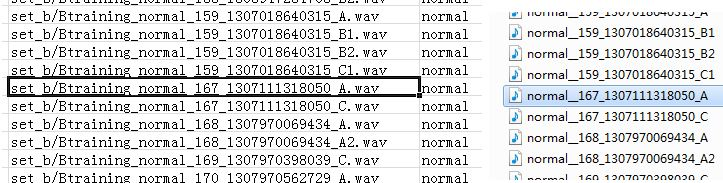

In [ ]:
# set_b
def rewrite_filename(fname): # match filename
    file_name = fname.split('/')[1]        
    file_name = re.sub('Btraining_', '', file_name)
    if (file_name[6] == '_' and file_name[7] != 'n'):
        file_name = file_name[:6] + '_' + file_name[6:]
    if file_name[10] == '_':
        file_name = file_name[:10] + '_' + file_name[10:]
    return file_name

## Data preprocessing

Make all the data to the same length

In [4]:
def repeat_to_length(array, length): 
    ## Repeat the numpy 1D array to given length, and makes datatype float
    result = np.empty((length, ), dtype = 'float32')
    l = len(array)
    pos = 0
    while pos + l <= length:
        result[pos:pos+l] = array 
        pos += l
    if pos < length:
        result[pos:length] = array[:length-pos] 
    return result

In [5]:
df = pd.read_csv(INPUT_LIB + 'set_a.csv')
df['fname'] = df['fname'].apply(rewrite_filename, string='Aunlabelledtest') 
df['label'] = df['label'].fillna('unclassified') 
df['time_series'] = df['fname'].apply(load_wav_file, path=INPUT_LIB + 'set_a/') # load file
df['len_series'] = df['time_series'].apply(len)
MAX_LEN = max(df['len_series'])
df['time_series'] = df['time_series'].apply(repeat_to_length, length=MAX_LEN) # make all the data same length (max length)
print('MAX_LEN:', MAX_LEN)
new_labels = pd.read_csv(INPUT_LIB + 'new_labels.csv')

MAX_LEN: 396900


In [209]:
x_data = np.stack(df['time_series'].values, axis=0) 
y_data = np.transpose(new_labels.values)

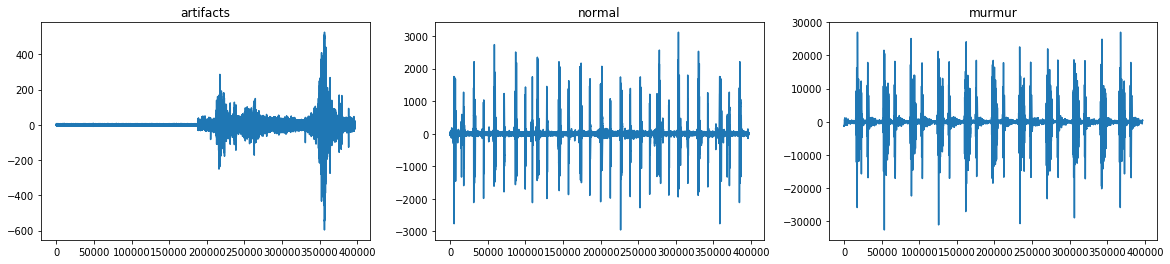

In [27]:
fig = plt.figure(figsize=(20,4))

fig1 = fig.add_subplot(1,3,1)
plt.plot(x_data[1])
plt.title('artifacts')
fig2 = fig.add_subplot(1,3,2)
plt.plot(x_data[100])
plt.title('normal')
fig3 = fig.add_subplot(1,3,3)
plt.plot(x_data[82])
plt.title('murmur')
plt.show()

Downsample

In [210]:
x_data = decimate(x_data, 8, axis=1, zero_phase=True) # Downsample by using a low pass filter (order 8 Chebyshev type I)
x_data = decimate(x_data, 8, axis=1, zero_phase=True) # downsampling factors higher than 13: multiple times
x_data = decimate(x_data, 4, axis=1, zero_phase=True) 

Regularization

In [163]:
## Scale each observation to unit variance, it should already have mean close to zero
x_data = x_data / np.std(x_data, axis=1).reshape(-1,1) 

#### Convert the wavefile to frequency information by FFT

In [13]:
Fs = 44100; # sampling rate
Ts = 1.0/Fs; # sampling interval 
t = np.arange(0,len(x_data[1])/Fs,Ts) # time vector (step)
y = x_data
n = len(y[1]) # length of the signal
k = np.arange(n)
T = n/Fs
frq = k/T # two sides frequency range
frq1 = frq[range(int(n/2))] # one side frequency range
#YY = np.fft.fft(y) 
x_data = np.fft.fft(y)/n # fft computing and normalization 

E:\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


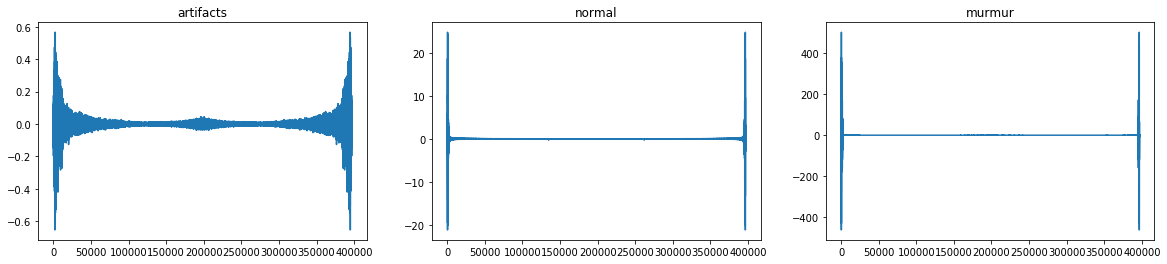

In [8]:
fig = plt.figure(figsize=(20,4))

fig1 = fig.add_subplot(1,3,1)
plt.plot(x_data[1])
plt.title('artifacts')
fig2 = fig.add_subplot(1,3,2)
plt.plot(x_data[100])
plt.title('normal')
fig3 = fig.add_subplot(1,3,3)
plt.plot(x_data[82])
plt.title('murmur')
plt.show()

E:\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


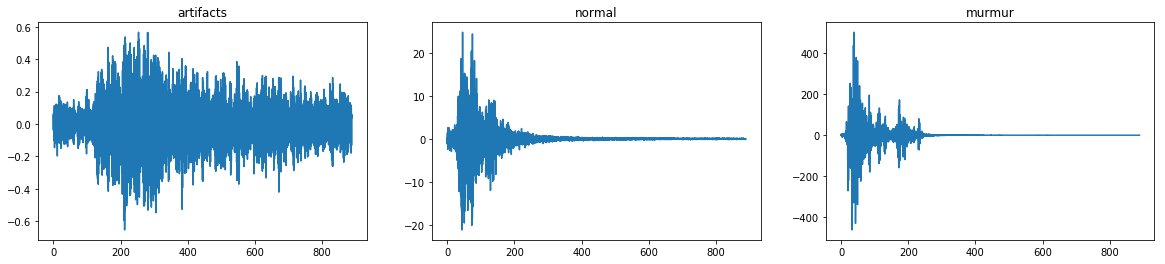

In [14]:
x_data_fft = x_data[:, 0:8000]

fig = plt.figure(figsize=(20,4))

fig1 = fig.add_subplot(1,3,1)
plt.plot(frq[:8000], x_data_fft[1])
plt.title('artifacts')
fig2 = fig.add_subplot(1,3,2)
plt.plot(frq[:8000], x_data_fft[100])
plt.title('normal')
fig3 = fig.add_subplot(1,3,3)
plt.plot(frq[:8000], x_data_fft[82])
plt.title('murmur')
plt.show()

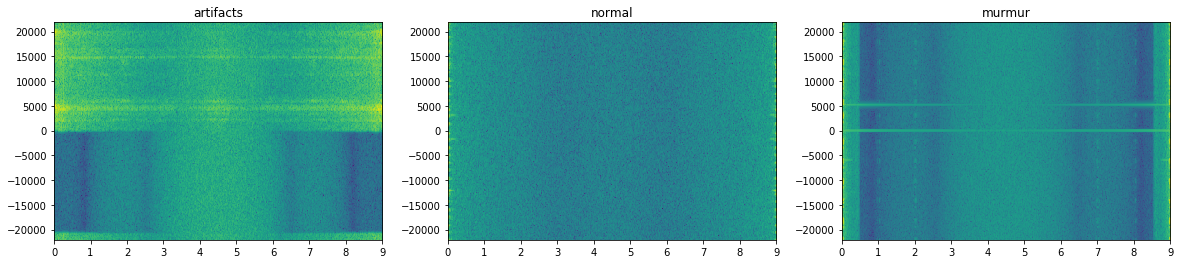

In [171]:
fig = plt.figure(figsize=(20,4))

fig1 = fig.add_subplot(1,3,1)
pl.specgram(x_data[1],Fs=44100)
plt.title('artifacts')
fig2 = fig.add_subplot(1,3,2)
pl.specgram(x_data[100],Fs=44100)
plt.title('normal')
fig3 = fig.add_subplot(1,3,3)
pl.specgram(x_data[82],Fs=44100)
plt.title('murmur')
plt.show()

# Model Selection, Comparison and Cross Validation:

## SVM model

In [212]:
y_data = np.transpose(y_data)

K-fold cross validation

In [121]:
from sklearn import svm

kf = KFold(n_splits=5)

for train_index,test_index in kf.split(x_data): 
    x_train, x_test = x_data[train_index], x_data[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]

    clf=svm.SVC()
    clf_fit=clf.fit(x_train, y_train.ravel())
    pred = clf.predict(x_test)

    print('accuracy:', accuracy_score(pred, y_test))

accuracy: 0.0555555555556
accuracy: 0.114285714286
accuracy: 0.2
accuracy: 0.142857142857
accuracy: 0.371428571429


In [215]:
x_data = decimate(x_data_fft, 4, axis=1, zero_phase=True) 
x_data = x_data / np.std(x_data, axis=1).reshape(-1,1) 

In [204]:
# FFT
from sklearn import svm

kf = KFold(n_splits=5, random_state=0)

for train_index,test_index in kf.split(x_data): 
    x_train, x_test = x_data[train_index], x_data[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]

    clf=svm.SVC()
    clf_fit=clf.fit(x_train, y_train.ravel())
    pred = clf.predict(x_test)

    print('accuracy:', accuracy_score(pred, y_test))

accuracy: 0.0
accuracy: 0.285714285714
accuracy: 0.2
accuracy: 0.228571428571
accuracy: 0.4


E:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


## Logistic Regression model

In [105]:
from sklearn.linear_model import LogisticRegression

kf = KFold(n_splits=5)

for train_index,test_index in kf.split(x_data): 
    x_train, x_test = x_data[train_index], x_data[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]

    lr = LogisticRegression()
    lr_fit = lr.fit(x_train, y_train.ravel())
    pred = lr.predict(x_test)

    print('accuracy:', accuracy_score(pred, y_test))

accuracy: 0.416666666667
accuracy: 0.2
accuracy: 0.314285714286
accuracy: 0.171428571429
accuracy: 0.428571428571


In [200]:
# FFT
from sklearn.linear_model import LogisticRegression

kf = KFold(n_splits=5)

for train_index,test_index in kf.split(x_data): 
    x_train, x_test = x_data[train_index], x_data[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]

    lr = LogisticRegression()
    lr_fit = lr.fit(x_train, y_train.ravel())
    pred = lr.predict(x_test)

    print('accuracy:', accuracy_score(pred, y_test))

accuracy: 0.138888888889
accuracy: 0.371428571429
accuracy: 0.514285714286
accuracy: 0.371428571429
accuracy: 0.428571428571


E:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


## Random Forest model

In [112]:
from sklearn.ensemble import RandomForestClassifier

kf = KFold(n_splits=5)

i=0
acc1 = [0, 0, 0, 0, 0]
for train_index,test_index in kf.split(x_data): 
    x_train, x_test = x_data[train_index], x_data[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]

    forest = RandomForestClassifier(n_estimators=20,max_features=10,max_depth=20)
    forest_fit = forest.fit(x_train, y_train.ravel())
    pred = forest.predict(x_test)
    acc1[i] = accuracy_score(pred, y_test)
    i=i+1

    print('accuracy:', accuracy_score(pred, y_test))

accuracy: 0.111111111111
accuracy: 0.285714285714
accuracy: 0.2
accuracy: 0.2
accuracy: 0.542857142857


In [27]:
# FFT
from sklearn.ensemble import RandomForestClassifier

kf = KFold(n_splits=5)

i=0
acc = [0, 0, 0, 0, 0]
for train_index,test_index in kf.split(x_data): 
    x_train, x_test = x_data[train_index], x_data[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]

    forest = RandomForestClassifier(n_estimators=20,max_features=10,max_depth=20)
    forest_fit = forest.fit(x_train, y_train.ravel())
    pred = forest.predict(x_test)
    acc[i] = accuracy_score(pred, y_test)
    i=i+1

    print('accuracy:', accuracy_score(pred, y_test))

E:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
E:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
E:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
E:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


accuracy: 0.555555555556
accuracy: 0.685714285714
accuracy: 0.714285714286
accuracy: 0.628571428571
accuracy: 0.8


E:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
E:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


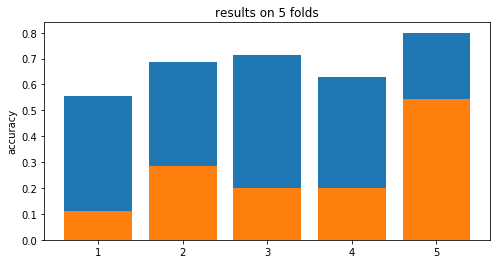

In [145]:
fig = plt.figure(figsize=(8,4))
index = [1,2,3,4,5]
plt.bar(index, acc)
plt.bar(index, acc1)
plt.ylabel('accuracy')
plt.title('results on 5 folds')
plt.show()

## Dense layer model

In [133]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=x_train.shape[1])) ## 64 hidden units
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(1e-4),
              metrics=['accuracy'])

hist = model.fit(x_train, y_train,
          epochs=100, validation_data=(x_test, y_test),
          batch_size=8, verbose=0)

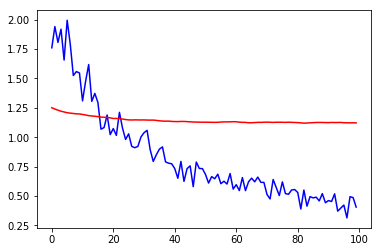

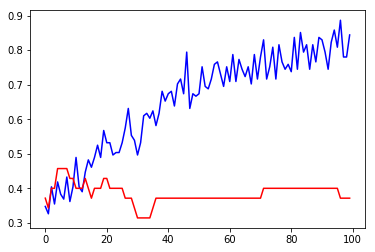

In [134]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [70]:
# FFT
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=x_train.shape[1])) ## 64 hidden units
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(1e-4),
              metrics=['accuracy'])

hist = model.fit(x_train, y_train,
          epochs=100, validation_data=(x_test, y_test),
          batch_size=8, verbose=0)

E:\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


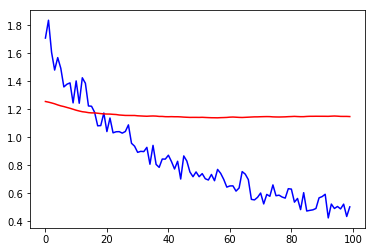

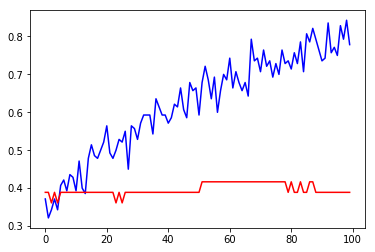

In [71]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

## CNN model

Feature Engineering

In [72]:
y_data = np_utils.to_categorical(new_labels) # 0=artifact, 1=normal, 2=murmur
y_data

array([[ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  1.

In [73]:
x_train, x_test, y_train, y_test, train_filenames, test_filenames = \
    train_test_split(x_data, y_data, df['fname'].values, test_size=0.2, random_state=37)

In [75]:
x_train = x_train[:,:,np.newaxis] # TensorFlow: need a channel dimension
x_test = x_test[:,:,np.newaxis]

In [75]:
model = Sequential()
model.add(Conv1D(filters=4, kernel_size=9, activation='relu', # 6 layer CNN
                input_shape = x_train.shape[1:], 
                kernel_regularizer = l2(0.025)))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization()) # after convolution layer
model.add(Conv1D(filters=4, kernel_size=9, activation='relu',
                kernel_regularizer = l2(0.05)))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=8, kernel_size=9, activation='relu',
                 kernel_regularizer = l2(0.1)))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=16, kernel_size=9, activation='relu'))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Dropout(0.25)) # prevent overfitting
model.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Conv1D(filters=32, kernel_size=1, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.75))
model.add(GlobalAvgPool1D()) 
model.add(Dense(3, activation='softmax')) # fully connected layer

In [76]:
def batch_generator(x_train, y_train, batch_size): 
    ## Rotate the time series randomly in time
    x_batch = np.empty((batch_size, x_train.shape[1], x_train.shape[2]), dtype='float32')
    y_batch = np.empty((batch_size, y_train.shape[1]), dtype='float32')
    full_idx = range(x_train.shape[0]) # samples
    
    while True:
        batch_idx = np.random.choice(full_idx, batch_size) 
        x_batch = x_train[batch_idx]
        y_batch = y_train[batch_idx]
    
        for i in range(batch_size):
            sz = np.random.randint(x_batch.shape[1])
            x_batch[i] = np.roll(x_batch[i], sz, axis = 0) # shift
     
        yield x_batch, y_batch

weight_saver = ModelCheckpoint('set_a_weights.h5', monitor='val_loss', # save best weights
                               save_best_only=True, save_weights_only=True) 

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy']) # learning rate, for multi-class
scheduler = LearningRateScheduler(lambda x: 1e-3 * 0.8**x) 

In [77]:
hist = model.fit_generator(batch_generator(x_train, y_train, 8), 
                   epochs=30, steps_per_epoch=1000, 
                   validation_data=(x_test, y_test),
                   callbacks=[weight_saver, scheduler],
                   verbose=2) 

Epoch 1/30
 - 21s - loss: 2.0477 - acc: 0.4108 - val_loss: 1.2776 - val_acc: 0.7500
Epoch 2/30
 - 15s - loss: 1.2896 - acc: 0.5944 - val_loss: 0.8203 - val_acc: 0.8333
Epoch 3/30
 - 14s - loss: 0.9893 - acc: 0.6866 - val_loss: 0.6180 - val_acc: 0.8889
Epoch 4/30
 - 15s - loss: 0.8348 - acc: 0.7301 - val_loss: 0.5270 - val_acc: 0.8611
Epoch 5/30
 - 15s - loss: 0.7358 - acc: 0.7590 - val_loss: 0.4632 - val_acc: 0.8333
Epoch 6/30
 - 14s - loss: 0.6500 - acc: 0.7946 - val_loss: 0.4558 - val_acc: 0.8611
Epoch 7/30
 - 15s - loss: 0.6339 - acc: 0.8004 - val_loss: 0.4098 - val_acc: 0.8333
Epoch 8/30
 - 14s - loss: 0.6094 - acc: 0.8097 - val_loss: 0.4337 - val_acc: 0.8056
Epoch 9/30
 - 14s - loss: 0.5703 - acc: 0.8246 - val_loss: 0.4256 - val_acc: 0.8056
Epoch 10/30
 - 15s - loss: 0.5468 - acc: 0.8299 - val_loss: 0.4447 - val_acc: 0.8333
Epoch 11/30
 - 14s - loss: 0.5421 - acc: 0.8275 - val_loss: 0.3998 - val_acc: 0.8333
Epoch 12/30
 - 14s - loss: 0.5210 - acc: 0.8356 - val_loss: 0.4128 - val_a

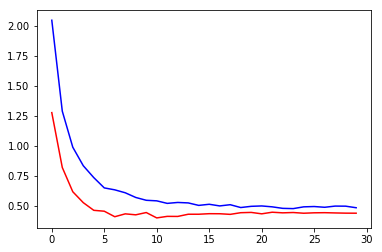

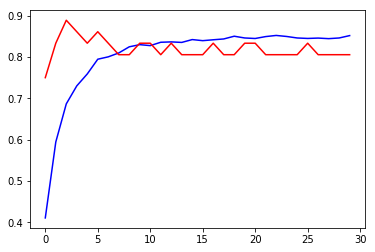

In [79]:
model.load_weights('set_a_weights.h5') 

plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

Class: artifact


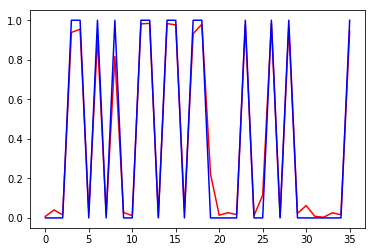

Class: normal


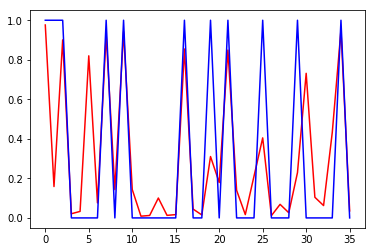

Class: murmur


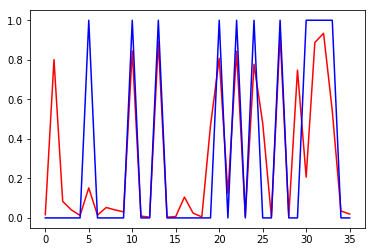

In [80]:
y_hat = model.predict(x_test)
np.set_printoptions(precision=2, suppress=True)
for i in range(3):
    print('Class:',CLASSES[i])
    plt.plot(y_hat[:,i], c='r')
    plt.plot(y_test[:,i], c='b')
    plt.show()

In [76]:
# FFT
model = Sequential()
model.add(Conv1D(filters=4, kernel_size=9, activation='relu', # 6 layer CNN
                input_shape = x_train.shape[1:], 
                kernel_regularizer = l2(0.025)))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization()) # after convolution layer
model.add(Conv1D(filters=4, kernel_size=9, activation='relu',
                kernel_regularizer = l2(0.05)))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=8, kernel_size=9, activation='relu',
                 kernel_regularizer = l2(0.1)))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=16, kernel_size=9, activation='relu'))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Dropout(0.25)) # prevent overfitting
model.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Conv1D(filters=32, kernel_size=1, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.75))
model.add(GlobalAvgPool1D()) 
model.add(Dense(3, activation='softmax')) # fully connected layer

def batch_generator(x_train, y_train, batch_size): 
    ## Rotate the time series randomly in time
    x_batch = np.empty((batch_size, x_train.shape[1], x_train.shape[2]), dtype='float32')
    y_batch = np.empty((batch_size, y_train.shape[1]), dtype='float32')
    full_idx = range(x_train.shape[0]) # samples
    
    while True:
        batch_idx = np.random.choice(full_idx, batch_size) 
        x_batch = x_train[batch_idx]
        y_batch = y_train[batch_idx]
    
        for i in range(batch_size):
            sz = np.random.randint(x_batch.shape[1])
            x_batch[i] = np.roll(x_batch[i], sz, axis = 0) # shift
     
        yield x_batch, y_batch

weight_saver = ModelCheckpoint('set_a_weights.h5', monitor='val_loss', # save best weights
                               save_best_only=True, save_weights_only=True) 

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy']) # learning rate, for multi-class
scheduler = LearningRateScheduler(lambda x: 1e-3 * 0.8**x) 

hist = model.fit_generator(batch_generator(x_train, y_train, 8), 
                   epochs=30, steps_per_epoch=1000, 
                   validation_data=(x_test, y_test),
                   callbacks=[weight_saver, scheduler],
                   verbose=2) 

Epoch 1/30


E:\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


 - 24s - loss: 1.8390 - acc: 0.4519 - val_loss: 1.1357 - val_acc: 0.6111
Epoch 2/30
 - 16s - loss: 1.1833 - acc: 0.5656 - val_loss: 0.8869 - val_acc: 0.6944
Epoch 3/30
 - 16s - loss: 1.0041 - acc: 0.6156 - val_loss: 0.9182 - val_acc: 0.5556
Epoch 4/30
 - 17s - loss: 0.9206 - acc: 0.6339 - val_loss: 0.7252 - val_acc: 0.7222
Epoch 5/30
 - 18s - loss: 0.8795 - acc: 0.6532 - val_loss: 0.7597 - val_acc: 0.7778
Epoch 6/30
 - 17s - loss: 0.8299 - acc: 0.6753 - val_loss: 0.6546 - val_acc: 0.7778
Epoch 7/30
 - 16s - loss: 0.7832 - acc: 0.6995 - val_loss: 0.7016 - val_acc: 0.5833
Epoch 8/30
 - 16s - loss: 0.7671 - acc: 0.7026 - val_loss: 0.6586 - val_acc: 0.8056
Epoch 9/30
 - 16s - loss: 0.7566 - acc: 0.7069 - val_loss: 0.6690 - val_acc: 0.7500
Epoch 10/30
 - 16s - loss: 0.7454 - acc: 0.7154 - val_loss: 0.6096 - val_acc: 0.8056
Epoch 11/30
 - 16s - loss: 0.7282 - acc: 0.7261 - val_loss: 0.6514 - val_acc: 0.6389
Epoch 12/30
 - 16s - loss: 0.7252 - acc: 0.7306 - val_loss: 0.6177 - val_acc: 0.7500


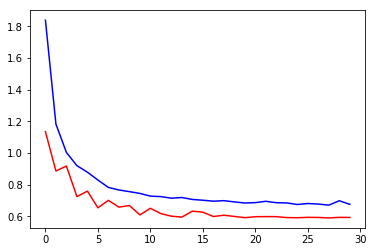

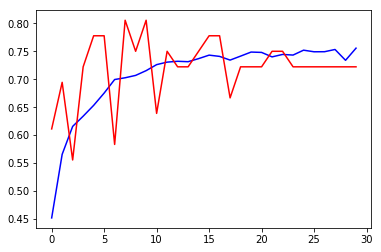

In [77]:
model.load_weights('set_a_weights.h5') 

plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

## set_b

# Conclusion